The purpose of this notebook is to create example json files (similar to however a backend API would be serving data) for the time matrix to be in the next version of the IMPACTS dashboard.

In [2]:
import pathlib
import glob
import os

import argparse
import geojson
import pandas as pd
import json
import random

from datetime import datetime, timedelta

In [3]:
# Helper array for day indexing
aggregateMonths = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
nsims = 10000

In [4]:
jsonResponse = []

In [5]:
# Read in example psv
file = '../data/output/examples/20210428124600.psv.gz'
df = pd.read_csv(file, sep="|")

<AxesSubplot:>

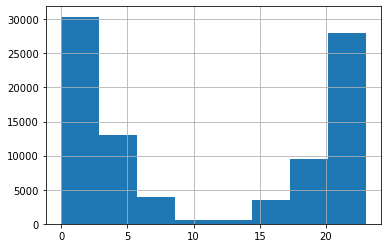

In [6]:
df['time'].hist(bins=8)

### Binning

In [16]:
bin_labels = ['00-03','03-06','06-09','09-12','12-15','15-18','18-21','21-00']
# lower bound is not inclusive, so we shift the thresholds one to the left
cut_bins = [-1,2,5,8,11,14,17,20,23]

# Add the hour bins to the original dataframe
df['hourBins'] = pd.cut(df['time'], bins=cut_bins, labels=bin_labels)

In [51]:
# Group by simulation and hour bin and sum our population in each group
grouped = df.groupby(['sim','hourBins']).agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})

# Move the indices to columns and pivot the sim column back to the index, then ensure we have 10000 sims in the df by reindexing
formatted = grouped.reset_index().pivot(index='sim',columns='hourBins').reindex(list(range(1,10001)),fill_value=0)

# Get the stats
hourBinStats_All = formatted.describe(percentiles=[0.1,0.5,0.9]).loc[['10%','50%','90%']]
hourBinStats_All.rename(index={'10%':'0.1','50%':'0.5','90%':'0.9'},inplace=True)


In [52]:
hourBinStats_All

population                                                     \
                sum                                                      
hourBins      00-03   03-06  06-09 09-12 12-15  15-18   18-21    21-00   
0.1             0.0     0.0    0.0   0.0   0.0    0.0     0.0      0.0   
0.5           608.0    16.0    0.0   0.0   0.0    0.0     0.0    608.0   
0.9         13958.4  3284.8  433.6   0.0   0.0  320.0  2977.6  10720.0   

         hospitals        ... psubstations       mobilehomes              \
               sum        ...          sum               sum               
hourBins     00-03 03-06  ...        18-21 21-00       00-03 03-06 06-09   
0.1            0.0   0.0  ...          0.0   0.0         0.0   0.0   0.0   
0.5            0.0   0.0  ...          0.0   0.0         0.0   0.0   0.0   
0.9            0.0   0.0  ...          1.0   3.0       100.0   0.0   0.0   

                                        
                                        
hourBins 09-12 12-15 15-18 18-21 21-00  
0.1        0.0   0.0   0.0   0.0   0.0  
0.5        0.0   0.0   0.0   0.0   0.0  
0.9        0.0   0.0   0.0   0.0  75.0  

[3 rows x 32 columns]

### No Binning

In [53]:
grouped_nb = df.groupby(['sim','time']).agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})

In [54]:
# Move the indices to columns and pivot the sim column back to the index, then ensure we have 10000 sims in the df by reindexing
formatted_nb = grouped_nb.reset_index().pivot(index='sim',columns='time').reindex(list(range(1,10001)),fill_value=0)

In [57]:
formatted_nb.fillna(0,inplace=True)

# Get the stats
hourBinStats_nb = formatted_nb.describe(percentiles=[0.1,0.5,0.9]).loc[['10%','50%','90%']]
hourBinStats_nb.rename(index={'10%':'0.1','50%':'0.5','90%':'0.9'},inplace=True)

In [58]:
hourBinStats_nb

population                                                            \
            sum                                                             
time         0       1       2      3      4      5     6    7    8    9    
0.1         0.0     0.0     0.0    0.0    0.0    0.0   0.0  0.0  0.0  0.0   
0.5        16.0     0.0     0.0    0.0    0.0    0.0   0.0  0.0  0.0  0.0   
0.9      3569.6  3569.6  1376.0  944.0  496.0  192.0  64.0  0.0  0.0  0.0   

      ... mobilehomes                                               
      ...         sum                                               
time  ...          14   15   16   17   18   19   20   21   22   23  
0.1   ...         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.5   ...         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.9   ...         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 96 columns]

In [42]:
nationalResponse = {
    'Location': 'National',
    'Type': 'National',
    'Timing': {}
}

In [43]:
impacts = ['population','hospitals','mobilehomes','psubstations']

In [44]:
for name in impacts:
    nationalResponse['Timing'][name] = {}
    
    for hourBin in hourBinStats_All[name]['sum'].columns:
        
        nationalResponse['Timing'][name][hourBin] = {}
        
        for quant in hourBinStats_All[name]['sum'].index:
            
            nationalResponse['Timing'][name][hourBin][quant] = \
                int(hourBinStats_All[name]['sum'].loc[quant,hourBin])

In [46]:
jsonResponse.append(nationalResponse)

### States

### CWAs

In [48]:
with open ('../data/output/examples/jsonResponse_time.json','w') as fp:
    json.dump(jsonResponse, fp)

In [49]:
jsonResponse

[{'Location': 'National',
  'Type': 'National',
  'Timing': {'population': {'00-03': {'0.1': 0, '0.5': 608, '0.9': 13958},
    '03-06': {'0.1': 0, '0.5': 16, '0.9': 3284},
    '06-09': {'0.1': 0, '0.5': 0, '0.9': 433},
    '09-12': {'0.1': 0, '0.5': 0, '0.9': 0},
    '12-15': {'0.1': 0, '0.5': 0, '0.9': 0},
    '15-18': {'0.1': 0, '0.5': 0, '0.9': 320},
    '18-21': {'0.1': 0, '0.5': 0, '0.9': 2977},
    '21-00': {'0.1': 0, '0.5': 608, '0.9': 10720}},
   'hospitals': {'00-03': {'0.1': 0, '0.5': 0, '0.9': 0},
    '03-06': {'0.1': 0, '0.5': 0, '0.9': 0},
    '06-09': {'0.1': 0, '0.5': 0, '0.9': 0},
    '09-12': {'0.1': 0, '0.5': 0, '0.9': 0},
    '12-15': {'0.1': 0, '0.5': 0, '0.9': 0},
    '15-18': {'0.1': 0, '0.5': 0, '0.9': 0},
    '18-21': {'0.1': 0, '0.5': 0, '0.9': 0},
    '21-00': {'0.1': 0, '0.5': 0, '0.9': 0}},
   'mobilehomes': {'00-03': {'0.1': 0, '0.5': 0, '0.9': 100},
    '03-06': {'0.1': 0, '0.5': 0, '0.9': 0},
    '06-09': {'0.1': 0, '0.5': 0, '0.9': 0},
    '09-12': {'0.1